In [1]:
# reduce log-level output
import logging
logging.getLogger().setLevel(logging.ERROR)

import matplotlib
from matplotlib import pyplot as plt

# Performance of a fictive radio detector
In this example, we will generate effective areas for a fictive radio detector. These will be used calculate event numbers for different assumptions on the instrument's performance. Finally, we will evaluate the sensitivity of the instrument for diffuse fluxes of ultra-high energy astrophysical neutrinos and predicted GZK neutrino flux models that are defined in the `toise` framework

## Preparation of fictive radio detectors for analysis
First, we are going to evaluate the distribution of detected events for different assumptions on the instrument's performance

In [2]:
import numpy as np
import toise
from toise import radio_aeff_generation
from toise import factory
from toise.util import constants

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


For the analysis, we choose a livetime of `nyears` years, and a fictive array of `nstations` stations.

In [3]:
nyears = 10
nstations = 30

Next we define the direction resolution binning. This is the last dimension of the toise effective area tuples.
Setting a lower `psi_max_rad` will exclude a fraction of the angular resolution CDF above `psi_max_deg` from analysis. For a diffuse analysis we will not constrain it for now, and also choose only a single bin.

In [4]:
psi_max_rad = np.pi
n_psi_bins = 1
psi_bins = np.sqrt(np.linspace(0, psi_max_rad**2, n_psi_bins))

We then generate a radio effective area with the resolution parameters for our fictive detector defined in a `.yaml` file, and update some of the parameters by hand

In [5]:
radio_array = radio_aeff_generation.radio_aeff('radio_config.yaml', psi_bins=psi_bins)
radio_array.set_parameter('detector_setup', 'nstations', nstations)

INFO:aeff calculation:{'apply_smearing_inelasticity': False, 'apply_analysis_efficiency': True, 'apply_energy_resolution': True, 'detector_setup': {'nstations': 144}, 'effective_volume': {'e': 'review_array_dict_e.json', 'mu': 'review_array_dict_mu.json', 'tau': 'review_array_dict_tau.json', 'trigger_name': 'combined_array', 'simulated_stations': 144}, 'analysis_efficiency': {'minval': 0.43725862, 'maxval': 0.99336176, 'log_turnon_gev': 8.21735254, 'log_turnon_width': 0.93403754}, 'energy_resolution': {'loc': 0.01868963, 'scale': 0.14255128}, 'angular_resolution': {'norm1': 0.6192978004334891, 'sigma1': 3.841393561107805, 'norm2': 0.2130050363262992, 'sigma2': 33.95551135597404, 'norm_const': 0.1676971632402118}}
INFO:aeff calculation:New parameter value: 30.000000


We are now ready to create the `toise` effective area tuples. A dummy atmospheric muon background may also be created, but a good assumption on what to expect here is still actively debated in the community at the moment. Let's use the provided distribution anyway without caring too much...

In [6]:
# TODO: in the yaml file these should be better set to true!!!!
# create toise effective areas from the radio array
radio_array.switch_analysis_efficiency(True)
radio_array.switch_energy_resolution(True)
radio_aeff = radio_array.create()

## rough dummy estimate for an atm. muon background...
backround_muons_aeff = radio_array.create_muon_background()

INFO:aeff calculation:using number of stations from config
INFO:aeff calculation:applying analysis efficiency as function of neutrino energy
INFO:aeff calculation:applying energy resolution smearing
INFO:radio resolution param:-- stored results:
INFO:radio resolution param:   norm1: 0.619297800433489
INFO:radio resolution param:   sigma1: 3.841393561107805
INFO:radio resolution param:   norm2: 0.21300503632629914
INFO:radio resolution param:   sigma2: 33.95551135597404
INFO:radio resolution param:   norm_const: 0.16769716324021178
INFO:aeff calculation:generated aeff of shape (6, 60, 20, 60, 1)
INFO:aeff calculation:using number of stations from config
INFO:aeff calculation:applying energy resolution smearing


('total muons per station:', 0.0226643337919)


In case we want to retrieve and use them later we add them to the `toise.factory` by hand. Note that the distributions we are generating now are not by default part of the factory.

In [7]:
factory.add_aeffs("radio_aeff", (radio_aeff, backround_muons_aeff))
# can also choose to ignore the atm. background by setting it to None
factory.add_aeffs("radio_aeff_nobackground", (radio_aeff, None))

Next, we turn some switches, to generate additional effective areas at trigger-level (i.e. we do not account tighter analysis selection) and also assume perfect energy resolution, to compare with the more realistic default `radio_aeff`.

In [8]:
radio_array.switch_analysis_efficiency(False)
radio_array.switch_energy_resolution(False)
radio_aeff_perfect_E_eff = radio_array.create()

radio_array.switch_analysis_efficiency(False)
radio_array.switch_energy_resolution(True)
radio_aeff_perfect_eff = radio_array.create()

radio_array.switch_analysis_efficiency(True)
radio_array.switch_energy_resolution(False)
radio_aeff_perfect_E = radio_array.create()

INFO:aeff calculation:using number of stations from config
INFO:radio resolution param:-- stored results:
INFO:radio resolution param:   norm1: 0.619297800433489
INFO:radio resolution param:   sigma1: 3.841393561107805
INFO:radio resolution param:   norm2: 0.21300503632629914
INFO:radio resolution param:   sigma2: 33.95551135597404
INFO:radio resolution param:   norm_const: 0.16769716324021178
INFO:aeff calculation:generated aeff of shape (6, 60, 20, 60, 1)
INFO:aeff calculation:using number of stations from config
INFO:aeff calculation:applying energy resolution smearing
INFO:radio resolution param:-- stored results:
INFO:radio resolution param:   norm1: 0.619297800433489
INFO:radio resolution param:   sigma1: 3.841393561107805
INFO:radio resolution param:   norm2: 0.21300503632629914
INFO:radio resolution param:   sigma2: 33.95551135597404
INFO:radio resolution param:   norm_const: 0.16769716324021178
INFO:aeff calculation:generated aeff of shape (6, 60, 20, 60, 1)
INFO:aeff calculat

In [9]:
# once again add all of them to factory, just in case
factory.add_aeffs("radio_aeff_perfect_E_eff",
                  (radio_aeff_perfect_E_eff, None))
factory.add_aeffs("radio_aeff_perfect_eff",
                  (radio_aeff_perfect_eff, None))
factory.add_aeffs("radio_aeff_perfect_E",
                  (radio_aeff_perfect_E, None))

# Observed event distribution for a diffuse astrophysical and GZK neutrino flux models
The effective areas we have generated above can now be used to evaluate and compared the distributions of events for different flux assumptions. Within the framework, diffuse neutrino fluxes are provided in `toise.diffuse`. For convenience, the flux plots are provided as functions here and may be fed with any set of previously defined effective area tuples.

In [54]:
from toise import diffuse

def icecube_flux_plot(gamma, norm,
                      aeff_names=["radio_aeff",
                                  "radio_aeff_perfect_E",
                                  "radio_aeff_perfect_eff",
                                  "radio_aeff_perfect_E_eff"],
                      aeff_labels=[r'analysis level, $E_{rec}$',
                                   r'analysis level, $E_{\nu\, sh}$',
                                   r'trigger level, $E_{rec}$',
                                   r'trigger level, $E_{\nu\, sh}$'],
                      nyears=1, title=None, original_binning=False, outfile=None):
    ## default full-decade binning unless origninal_binning is requested
    bb = np.logspace(6,12,13)
    edges = factory.get(aeff_names[0])['radio_events'][0].get_bin_centers('true_energy')
    ## original binning in framework
    if original_binning:
        bb = edges
    
    fig = plt.figure()
    ax = fig.subplots()

    n_events = []
    for aeff_name, aeff_label in zip(aeff_names, aeff_labels):
        print(aeff_name)
        aeff_nu = factory.get(aeff_name)['radio_events'][0]
        astro_w =  diffuse.DiffuseAstro(aeff_nu, nyears).expectations().sum(0)

        linestyle = "-"
        if "trigger" in aeff_label:
            linestyle = "--"
        (n, bins, patches) = ax.hist(edges,
                                      bins = bb,
                                      weights=astro_w * norm,
                                      histtype='step',
                                      label=aeff_label, linewidth=3, linestyle=linestyle)
        n_events.append(np.sum(n))
    ax.set_xscale('log')

    ax.set_xlabel('neutrino energy proxy [GeV]')
    ax.set_ylabel('# events / bin / %i years' %nyears)
    plot_title = 'diffuse flux'
    legend_title = r'$E^{%.2f}\Phi_{1\nu} = {%.2f}\cdot 10^{-8}\frac{{GeV}^{%.2f}}{{cm}^{2}{\ s\ sr}}$' %(-gamma, norm, -1-gamma)
    if not title is None:
        plot_title += ", " + title
    ax.set_title(plot_title)
    ax.set_xlim([1e6,1e12])
    ax.legend(title=legend_title)
    print('event numbers:', n_events)
    return n_events

In [55]:
from toise import diffuse

def gzk_flux_plot(gzk='VanVliet',
                  aeff_names=["radio_aeff",
                              "radio_aeff_perfect_E",
                              "radio_aeff_perfect_eff",
                              "radio_aeff_perfect_E_eff"],
                  aeff_labels=[r'analysis level, $E_{rec}$',
                               r'analysis level, $E_{\nu\, sh}$',
                               r'trigger level, $E_{rec}$',
                               r'trigger level, $E_{\nu\, sh}$'],
                  nyears=1, original_binning=False, title=None, outfile=None):
    ## half decade binning
    bb = np.logspace(6,12,13)
    ## original binning in framework
    edges = factory.get(aeff_names[0])['radio_events'][0].get_bin_centers('true_energy')
    if original_binning:
        bb = edges
        
    if gzk == 'VanVliet':
        obj = diffuse.VanVlietGZK
    elif gzk == 'Ahlers':
        obj = diffuse.AhlersGZK
    elif gzk == 'Reasonable':
        obj = diffuse.ReasonableGZK
    else:
        print("ERROR invalid flux")
    
    fig = plt.figure()
    ax = fig.subplots()

    n_events = []
    for aeff_name, aeff_label in zip(aeff_names, aeff_labels):
        print(aeff_name)
        astro_w =  obj(factory.get(aeff_name)['radio_events'][0], nyears).expectations().sum(0)
        linestyle = "-"
        if "trigger" in aeff_label:
            linestyle = "--"
        (n, bins, patches) = ax.hist(edges,
                                      bins = bb,
                                      weights=astro_w, histtype='step',
                                      label=aeff_label, linewidth=3, linestyle=linestyle)
        n_events.append(np.sum(n))

    ax.set_xscale('log')

    ax.set_xlabel('Neutrino energy [GeV]')
    ax.set_ylabel('# events / bin / %i years' %nyears)
    if title is not None:
        ax.set_title(r"%s GZK flux, %s" %(gzk, title))
    else:
        ax.set_title(r"%s GZK flux" %(gzk))
    ax.set_xlim([1e6,1e11])
    ax.legend(loc='upper left')
    print('event numbers:', n_events)
    if outfile is not None:
        fig.savefig(outfile + ".pdf")
        fig.savefig(outfile + ".png")
    return n_events

radio_aeff
radio_aeff_perfect_E
radio_aeff_perfect_eff
radio_aeff_perfect_E_eff
event numbers: [147.31266713603264, 153.08511150914126, 176.448554387001, 183.45671147305984]


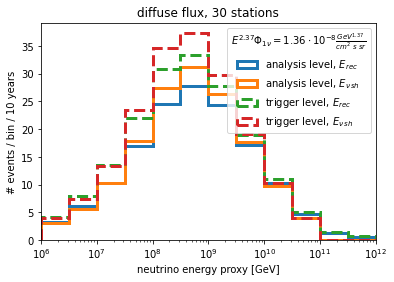

In [56]:
title = f"{nstations} stations"
flux_norm = 1.36
gamma = -2.37
n_events_total_per_array = icecube_flux_plot(gamma=gamma, norm=flux_norm, nyears=nyears, original_binning=False, title=title, outfile=None)

radio_aeff
radio_aeff_perfect_E
radio_aeff_perfect_eff
radio_aeff_perfect_E_eff
event numbers: [7.96235393297198, 8.270355964841801, 9.60873824092303, 9.982830900890068]


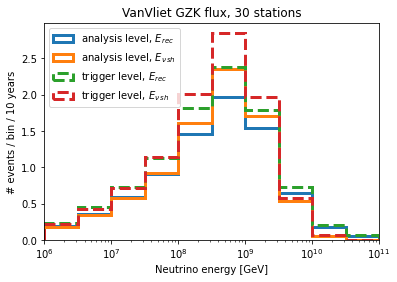

In [57]:
title = f"{nstations} stations"
n_events_total_per_array = gzk_flux_plot(gzk='VanVliet', 
    nyears=nyears, original_binning=False, title=title, outfile='GZK_flux_figure')

In [49]:
#TODO: rename 'Reasonable' in framework... we have the same naming in NuRadioMC, but a citation would be in order... == 'gzk_reasonable_bestFitToAuger_10percentProton'

One may also inspect the event distributions in true cos(zenith) bins and reconstructed energy

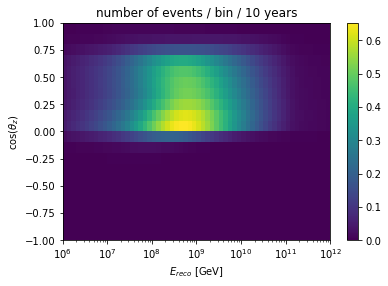

In [38]:
from toise import diffuse
from matplotlib.colors import LogNorm #logarithmic coloring


astro = diffuse.DiffuseAstro(radio_aeff, nyears).expectations()

plt.pcolormesh(radio_aeff.get_bin_edges('true_energy'),
               radio_aeff.get_bin_edges("true_zenith_band"),
               astro)
plt.xlabel(r"$E_{reco}$ [GeV]")
plt.ylabel(r"cos($\theta_z$)")
plt.title(f"number of events / bin / {nyears} years")
plt.semilogx()
plt.colorbar()

This shows a general property, that UHE neutrino fluxes are absorbed by the Earth below horizon, and become invisible for low theta (cos(theta) close to one).

# Comparison of the neutrino energy distribution of detected astrophysical and GZK neutrino fluxes
now that we have plotted the reconstructed energy distribution for an astrophysical and a GZK neutrino flux model, let's look at the true neutrino energy distribution of the detected events. For this, we use the `differential_chunks` member function

/Users/brianclark/Documents/work/Gen2/optical/testing_new_framework/toise/toise/diffuse.py:839: RuntimeWarning: divide by zero encountered in log10
  logWeight = np.log10(Weight)  # flux is expected for all-flavour


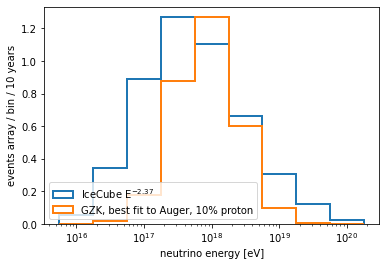

In [39]:
edges = np.logspace(15.75,20.25,10)

gamma = -2.37
flux_norm = 1.36

# for a diffuse flux, we can just scale by the number of years x normalisation
diff_astro = diffuse.DiffuseAstro(radio_aeff, nyears*flux_norm)

arr = []
for E, fluxchunk in diff_astro.differential_chunks(decades=0.1, exclusive=True):
    n_events = fluxchunk.expectations(gamma=gamma).sum()
    arr.append([E, n_events])
arr = np.array(arr)

plt.hist(arr[:,0]*1e9 , bins=edges, weights=arr[:,1], histtype='step', label=r'IceCube E$^{-2.37}$', linewidth=2)


diff_gzk = diffuse.ReasonableGZK(radio_aeff, nyears)

arr = []
for E, fluxchunk in diff_gzk.differential_chunks(decades=0.1, exclusive=True):
    n_events = fluxchunk.expectations().sum()
    arr.append([E, n_events])
arr = np.array(arr)

plt.hist(arr[:,0]*1e9 , bins=edges, weights=arr[:,1], histtype='step', label=r'GZK, best fit to Auger, 10% proton', linewidth=2)

plt.semilogx()
plt.xlabel('neutrino energy [eV]')
plt.ylabel(f'events array / bin / {nyears} years')
plt.legend(loc=3)


# Diffuse flux sensitivity

In [65]:
# TODO